In [1]:
library(tidyr)
library (coda)
library(car)
library(reshape2)



ERROR: Error in library(coda): there is no package called ‘coda’


In [2]:
#raw data
header <- sprintf("NS%d",seq(1:11))
df <- log(t(read.csv('http://www.stat.columbia.edu/~gelman/book/data/schiz.asc',sep = ' ',
                     skip=4, nrows=11, header=F)))
colnames(df) <- header; rownames(df) <- c(1:30)
yBar <- colMeans(df)
yVar <- apply(df,2,var)
ySD <- sqrt(yVar)
n <- 30
s <- 11
ySS <- yVar*(n-1)+n*yBar^2   # sum of squares
print(head(df))

       NS1      NS2      NS3      NS4      NS5      NS6      NS7      NS8
1 5.743003 5.869297 5.545177 5.560682 5.318120 6.380123 5.730100 5.497168
2 5.605802 5.846439 5.648974 5.683580 5.605802 5.743003 5.897154 5.480639
3 5.857933 5.950643 5.768321 5.723585 5.521461 5.655992 5.924256 5.627621
4 5.655992 5.834811 5.613128 5.676754 5.560682 5.736572 5.627621 5.568345
5 5.590987 5.710427 5.780744 5.575949 5.749393 6.656727 5.902633 5.583496
6 5.793014 5.743003 5.590987 5.669881 5.730100 5.897154 5.736572 5.537334
       NS9     NS10     NS11
1 5.446737 5.762051 5.480639
2 5.568345 5.780744 5.676754
3 5.438079 5.641907 5.857933
4 5.402677 5.897154 5.537334
5 5.347108 5.655992 5.981414
6 5.648974 5.834811 6.063785


In [3]:
#weak priors (given)
mu0 <- log(250)   # typical reaction time to visual stimulus is 0.25 sec
sigma0 <- .22
tau.sh.0 <- sig.sh.0 <- 1/2    # Use small virtual sample size (Shape)
tau.sc.0 <- sig.sc.0 <- 50     # prior scale gives expected precision of 25 (Scale)

In [4]:
sim <- 5000
theta.mcmc <- matrix(nrow = sim, ncol = s)
theta.mcmc[1,] <- yBar   # initial value for theta
mu.mcmc <- mean(yBar)    # initial value for mu
tau.mcmc <- sd(yBar)     # initial value for tau
sig.mcmc <- mean(ySD)    # initial value for sigma

Gibbs Sampler with Semi Conjugate prior

In [5]:
#MCMC algo
for (k in 2:sim) {
  mu1 <- (mu0/sigma0^2+sum(theta.mcmc[k-1,])/tau.mcmc[k-1]^2)/(1/sigma0^2+s/tau.mcmc[k-1]^2)
  sigma1 <- (1/sigma0^2+s/tau.mcmc[k-1]^2)^(-.5)
  mu.mcmc[k] <- rnorm(1,mu1, sigma1)    # sample new mu
  
  tau.sh.1 <- tau.sh.0 + 0.5*s  # this is the same every iteration
  tau.sc.1 <- (1/tau.sc.0 + 0.5*sum((theta.mcmc[k-1,]-mu.mcmc[k])^2))^-1
  tau.mcmc[k] <- rgamma(1,shape=tau.sh.1,scale=tau.sc.1)^(-.5)
  
  sig.sh.1 = sig.sh.0 + 0.5*s*n  # this is the same every iteration
  # In the formula below, sum(ySS - n*yBar^2 + n*(theta.mcmc[k-1,]-yBar)^2) is
  # equal to the sum of squared deviatons of each subject's observations and
  # that subject's theta value. 
  sig.sc.1 = (1/sig.sc.0 + 0.5*sum(ySS - n*yBar^2 + n*(theta.mcmc[k-1,]-yBar)^2))^-1
  sig.mcmc[k] = rgamma(1,shape=sig.sh.1,scale=sig.sc.1)^(-1/2)
  
  mu2 <- (mu.mcmc[k]/tau.mcmc[k]^2+yBar*n/sig.mcmc[k]^2)/(1/tau.mcmc[k]^2+n/sig.mcmc[k]^2) # vector of posterior means
  tau2 <- (1/tau.mcmc[k]^2+n/sig.mcmc[k]^2)^(-1/2)  # vector of posterior SDs
  theta.mcmc[k,] = rnorm(s,mu2,tau2)
}


In [6]:
#Generate Credible Intervals
theta.hat <- colMeans(theta.mcmc)
th025<-th975<-NULL
for (i in 1:s) {
  th025[i] = quantile(theta.mcmc[,i],0.025)
  th975[i] = quantile(theta.mcmc[,i],0.975)
}

# Table of credible intervals
results<-as.data.frame(th025)
results$th975<-th975
colnames(results)<-c("2.5%","97.5%")
rownames(results) <- paste("theta",c(1:11),sep="_")
mu025<-quantile(mu.mcmc,0.025)
mu975<-quantile(mu.mcmc,0.975)
tau025<-quantile(tau.mcmc,0.025)
tau975<-quantile(tau.mcmc,0.975)
sig025<-quantile(sig.mcmc,0.025)
sig975<-quantile(sig.mcmc,0.975)

results[12,]<-c(mu025,mu975)
results[13,]<-c(tau025,tau975)
results[14,]<-c(sig025,sig975)
rownames(results)[12:14] = c("mu","tau","sig")
print(results)

              2.5%     97.5%
theta_1  5.6751084 5.7860260
theta_2  5.8297843 5.9445431
theta_3  5.6547643 5.7651808
theta_4  5.6504224 5.7617949
theta_5  5.5211609 5.6326730
theta_6  5.7373484 5.8504667
theta_7  5.8009607 5.9152744
theta_8  5.5324073 5.6445497
theta_9  5.4956760 5.6063450
theta_10 5.7179365 5.8307824
theta_11 5.6603075 5.7716979
mu       5.6243562 5.7911852
tau      0.0860066 0.2116579
sig      0.1482716 0.1730829


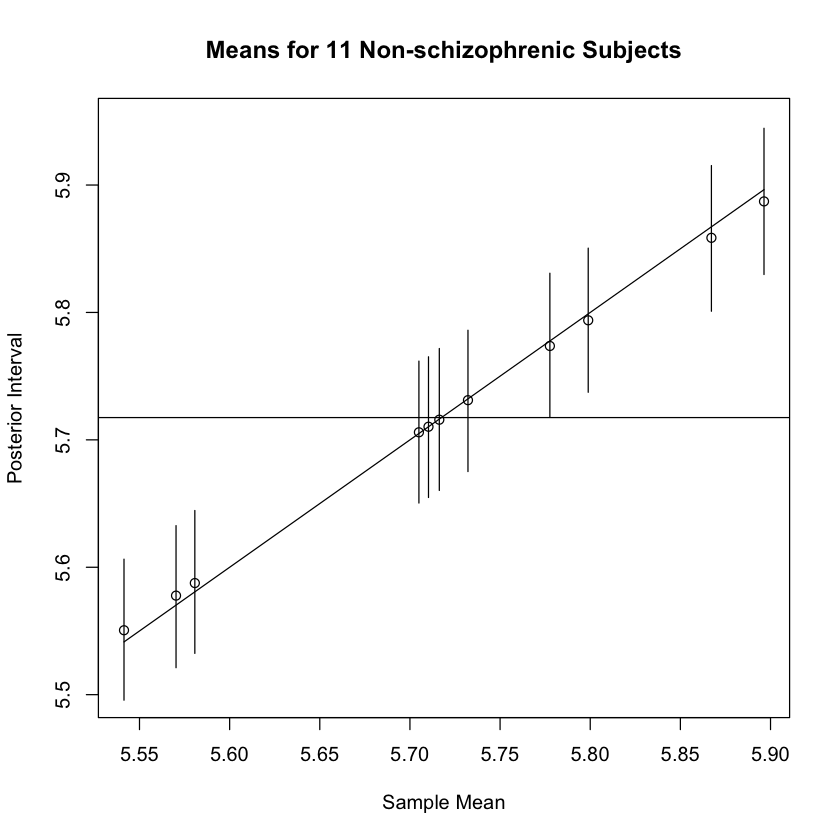

In [7]:
# Caterpillar plot for Theta
plot(yBar,theta.hat,main = "Means for 11 Non-schizophrenic Subjects",
     ylab="Posterior Interval",xlab="Sample Mean", ylim = c(5.5,5.95))
lines(yBar,yBar)
for (i in 1:s) {
  lines(c(yBar[i],yBar[i]),c(results$`2.5%`[i],results$`97.5%`[i]))
}
lines(1:11,array(mean(theta.hat),11))  # Plotting this line shows clearly that means are different
